In [1]:
import os.path
import pandas as pd
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
import datetime as dt
from google.api_core import exceptions
import matplotlib.pyplot as plt

In [109]:
SCOPES = ['https://www.googleapis.com/auth/drive.readonly']
today = dt.date.today().strftime("%m_%d_%Y")
# this is ID for recon live: instilend
SPREADSHEET_ID = '1pzlQEQE4FI4OnGrhKMfu1Skwrvs-FubYuEn-Ez5HpsM'
creds = None
# The file token.json stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token.json'):
        creds = Credentials.from_authorized_user_file('token.json', SCOPES)
'''flow = InstalledAppFlow.from_client_secrets_file('client_secret_510599516312-aj6d72c90n3fmrbf3ou6gromil06pr8c.apps.googleusercontent.com.json', SCOPES)
creds = flow.run_local_server(port=0)
with open('token.json', 'w') as token:
    token.write(creds.to_json())'''
service = build('drive', 'v3', credentials=creds)

# Call the Drive v3 API
results = service.files().export_media(
        fileId = SPREADSHEET_ID,
        mimeType = 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet').execute()#
path = f"source/Portolio_History_{today}.xlsx"
with open(path, "wb") as f:
    f.write(results)
    f.close()

pivot_data = pd.read_excel(path, 'Pivot_Data')
pivot_data['Timestamp - UTC'] = pivot_data['Timestamp - UTC'].map(lambda x:x[:10])

In [110]:
def history_account_plot(table, account, coin):
    cond = (table['Account']==account)&(table['Coin']==coin)
    df = table[cond]
    df.set_index('Timestamp - UTC', inplace=True)

    df['# of Coins'].plot(figsize=(20,5))
    plt.xticks(rotation=60)
    plt.ylabel('Coin Amount')
    plt.title(f'# of Coins in {account} --- {coin}')
    plt.plot()

    df[['APY','COFA']] = df[['APY','COFA']]*100
    df[['APY','COFA']].plot(figsize=(20,5))
    plt.xticks(rotation=60)
    plt.ylabel('%')
    plt.legend()
    plt.title(f'APY-COFA in {account} --- {coin}')
    plt.plot()

def history_category_plot(table, category, coin):
    category = category.lower()
    table['Category'] = table['Category'].str.lower()
    cond = (table['Category']==category) & (table['Coin']==coin)
    df_category = table[cond]
    print(df_category.shape)
    total_day = df_category.groupby('Timestamp - UTC')['# of Coins'].sum()
    total_day.plot(figsize=(10,5))
    plt.xticks(rotation=60)
    plt.ylabel('Coin Amount')
    plt.title(f"Coin Amount in {category.capitalize()} - {coin}")
    plt.plot()

    total_day = total_day.reset_index()
    total_day.columns = ['Timestamp - UTC', 'Total_Coin']
    df_category = df_category.merge(total_day, on='Timestamp - UTC', how='left')
    df_category['Coin %'] = df_category['# of Coins']/df_category['Total_Coin']
    df_category['Weighted_APY']= df_category['Coin %'] * df_category['APY']
    df_category['Weighted_COFA']= df_category['Coin %'] * df_category['COFA']
    apy_cofa_daily = df_category.groupby('Timestamp - UTC')[['Weighted_APY','Weighted_COFA']].sum() * 100
    apy_cofa_daily.plot(figsize=(10,5))
    plt.xticks(rotation=60)
    plt.title(f'APY-COFA History {category.capitalize()} - {coin}')
    plt.plot()

#history_account_plot(pivot_data, 'Direct Staking', 'ETH')

(189, 20)


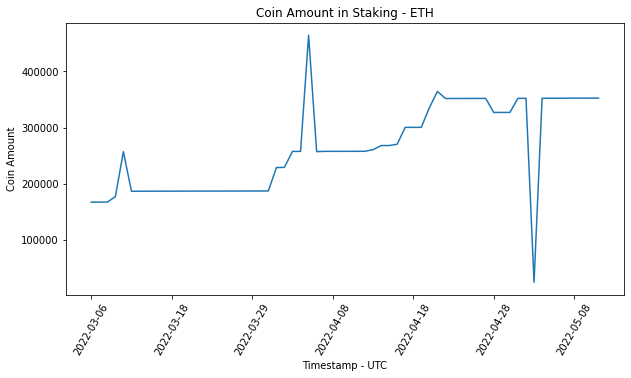

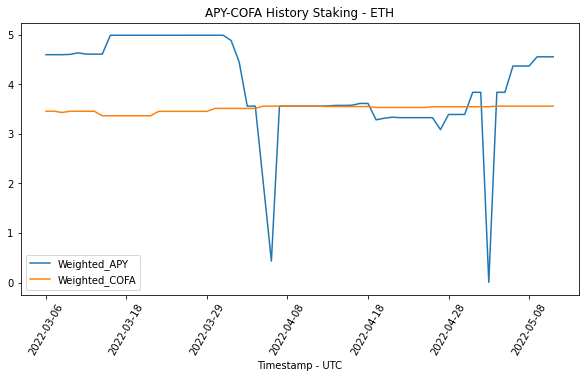

In [111]:
history_category_plot(pivot_data, 'Staking','ETH')

(2829, 20)


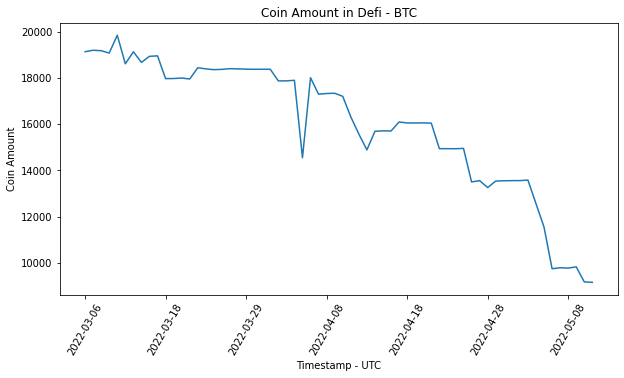

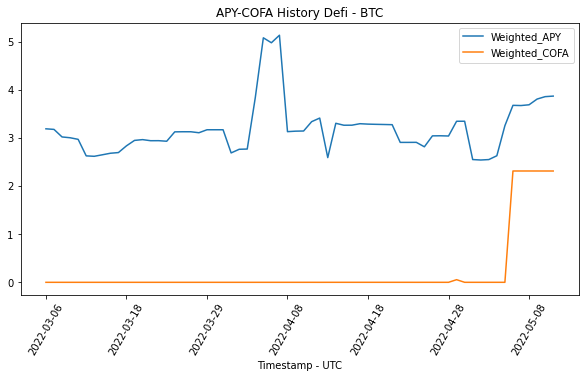

In [112]:
history_category_plot(pivot_data,'DEFI','BTC')

(8783, 20)


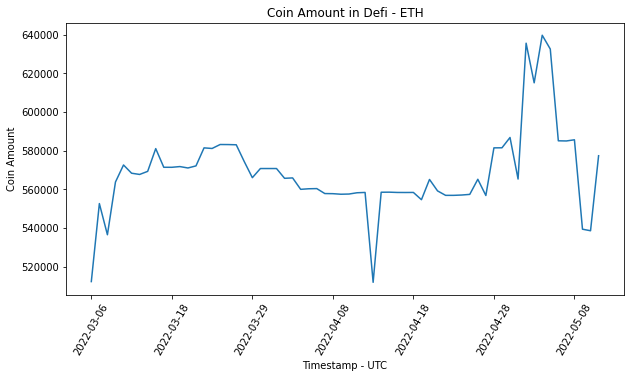

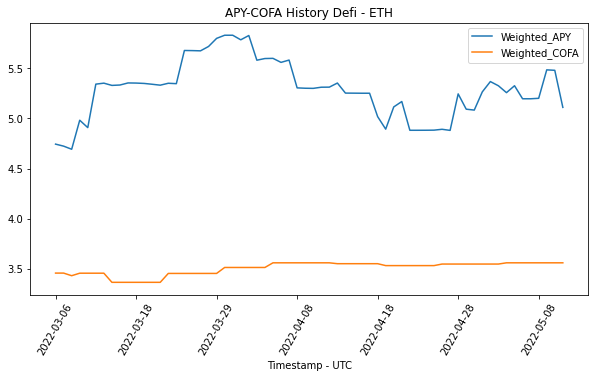

In [113]:
history_category_plot(pivot_data,'DEFI','ETH')